In [10]:
"""
Topic: Using Isolation Forest(IF) and Extended Isolation Forest (EIF)

Date 10/7/19
Souce:
Extended Isolation Forest (EIF)
- Hariri, S., Kind, M. C., & Brunner, R. J. (2018). Extended Isolation Forest. _arXiv preprint arXiv_:1811.02141.
- https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b
- https://linuxize.com/post/how-to-install-pip-on-ubuntu-18.04/
- https://github.com/sahandha/eif

Isolation Forest (IF)
- https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e
- https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

Contour Label
- https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py

Data_Set + Score Calculation
- http://odds.cs.stonybrook.edu/
- https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b

Goals
1. Compare anomaly score map of EIF and IF
2. Compare outlier detection performance of EIF and IF
3. Use USPORF in outlier detection

"""

# Goal 1: Compare anomaly score map of EIF and IF
## importing libaries ---
%matplotlib inline
import matplotlib.pyplot as plt #plot
import numpy as np #basic calculation
from scipy.stats import multivariate_normal
import random as rn
import eif as iso #download Isolation Forest
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage 
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed #create the same random
import numpy as np 
import pandas as pd 

## Utility Function
#>>> Creating the radial plots below. 
#>>> We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree.
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)
        
def getVals(forest,x, sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for t in forest.Trees:
        r.append(getDepth(x,t.root,1))
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

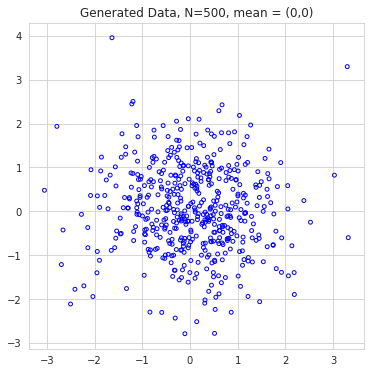

In [2]:
## Single Blob Example
###  Generate data
#>>> Produce a single blob of 2-D data normally distributed with mean [0,0] 
#>>> and covariance of identity. We also add some outliers manually to the data for testing.
mean = [0, 0]
cov = [[1,0], [0, 1]]  # covariance matrix: R^(2x2)
Nobjs = 500 # sample population
np.random.seed(1) # for a repeatable result
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T 
x[0]=3.3  # adjust manual outlier
y[0]=3.3
X=np.array([x,y]).T # transpose

fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.scatter(x,y,s=15,c='None',edgecolor='blue') 
plt.title('Generated Data, N=500, mean = (0,0)')
plt.show()




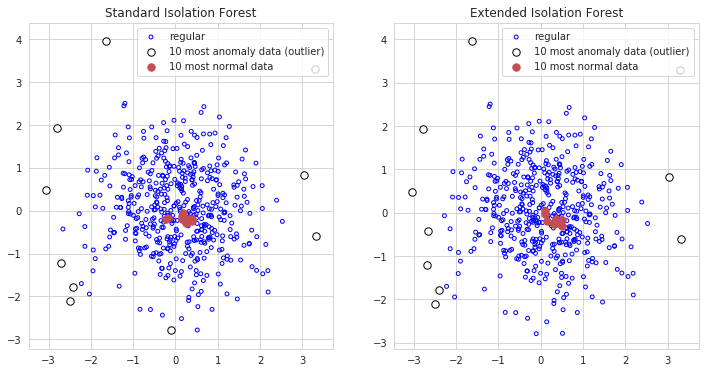

In [3]:
### Train Forest(s)
#>>> F0 is the standard Isolation Forest
#>>> F1 is the Extended Isolation Forest with extension 1
F0  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=0)
F1  = iso.iForest(X, ntrees=100, sample_size=256, ExtensionLevel=1)

### Anomaly (Outlier) Score
S0 = F0.compute_paths(X_in=X)
S1 = F1.compute_paths(X_in=X)
ss0=np.argsort(S0) # index element from low to high
ss1=np.argsort(S1)
#>>> x = np.array([3, 1, 2])
#>>> np.argsort(x)
#: array([1, 2, 0])

### Plot
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='None',edgecolor='blue')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='w',edgecolor='black')
plt.scatter(x[ss0[:10]],y[ss0[:10]],s=55,c='r')
plt.title('Standard Isolation Forest')
plt.legend(['regular','10 most anomaly data (outlier)','10 most normal data'])
plt.locs = (["best"])

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='None',edgecolor='blue')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=55,c='w',edgecolor='black')
plt.scatter(x[ss1[:10]],y[ss1[:10]],s=55,c='r')
plt.title('Extended Isolation Forest')
plt.legend(['regular','10 most anomaly data (outlier)','10 most normal data'])
plt.locs = (["best"])

plt.show()


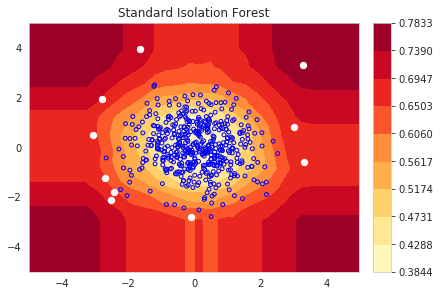

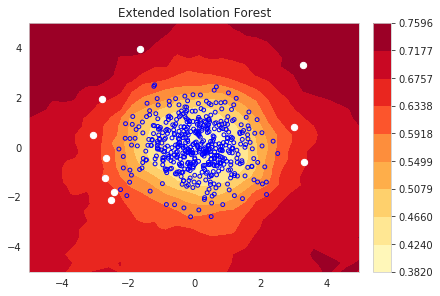

In [4]:
## (Outlier) Socre map s(x,n)
#>>> create a contour plot of score map
xx, yy = np.meshgrid(np.linspace(-5., 5., 30), np.linspace(-5., 5, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()]) # flatten: make 2D line space -> 1D
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

#>>> create scatter plot
#f = plt.figure(figsize=(12,6))

fig1, ax1= plt.subplots(constrained_layout=True)
#ax1 = f.add_subplot(121)
levels = np.linspace(np.min(S0),np.max(S0),10)
CS1 = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)
#plt.clabel(CS, [levels]) #
cbar = fig1.colorbar(CS1)#
#cbar.ax1.set_ylabel('anomaly score')

plt.scatter(x,y,s=15,c='None',edgecolor='blue')
plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=40,c='w') # 10 points with most anomolity
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Standard Isolation Forest')

fig2, ax2= plt.subplots(constrained_layout=True)
#ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S1),10)
CS2 = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
cbar = fig2.colorbar(CS2)#
#cbar.ax2.set_ylabel('anomaly score')

plt.scatter(x,y,s=15,c='None',edgecolor='blue')
plt.scatter(x[ss1[-10:]],y[ss1[-10:]],s=40,c='w') # 10 points with most anomolity
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title('Extended Isolation Forest')


plt.show()

In [5]:
# Goal2: Compare outlier detection performance of EIF and IF

In [19]:
## Import Data 

import scipy.io as sio

mat = scipy.io.loadmat('vertebral.mat')
X = pd.DataFrame(mat['X'])
y = pd.Series([x[0] for x in mat['y']])

# define % of anomalies
anomalies_ratio = 0.009

In [23]:

if_eif = iso.iForest(X.values, 
                     ntrees = 100, 
                     sample_size = 100, 
                     ExtensionLevel = 0)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = X.values)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
# create predictions 
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

if_eif = iso.iForest(X.values, 
                     ntrees = 100, 
                     sample_size = 100, 
                     ExtensionLevel = 1)

# calculate anomaly scores
anomaly_scores = if_eif.compute_paths(X_in = X.values)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X.shape[0])):]
# create predictions 
y_pred = np.zeros_like(y)
y_pred[indices_with_preds] = 1

In [24]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])